In [8]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import galsim
from dataset import Galaxy_Dataset, get_COSMOS_Galaxy, get_LSST_PSF

%matplotlib inline

In [9]:
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/'
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))

fov_pixels = 12
pixel_scale = 0.2
gal_max_shear = 0.5
seeing = 0.7
atmos_max_shear = 0.2

In [10]:
random_seed = 45 # randomly choose a seed for the rng
rng = galsim.UniformDeviate(seed=random_seed+235) # Initialize the random number generator
rng_gaussian = galsim.GaussianDeviate(seed=random_seed-2, mean=seeing, sigma=0.18)
atmos_fwhm = 0.45 # arcsec (mean 0.7 for LSST)
# while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
#     atmos_fwhm = rng_gaussian()
atmos_e = rng() * atmos_max_shear # ellipticity of atmospheric PSF
atmos_beta = 2. * np.pi * rng()     # radians
atmos_shear = galsim.Shear(e=atmos_e, beta=atmos_beta * galsim.radians)
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 8.36 # telescope diameter / meters (8.36 for LSST, 6.5 for JWST)

## Seeing Error

In [11]:
seeing_errs=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
noisy_psfs = []

for seeing_err in seeing_errs:
    delta = seeing_err
    noisy_psfs.append(get_LSST_PSF(lam, tel_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                                   atmos_fwhm + delta, atmos_e, atmos_beta, 0, 0, 
                                   fov_pixels, pixel_scale=pixel_scale))

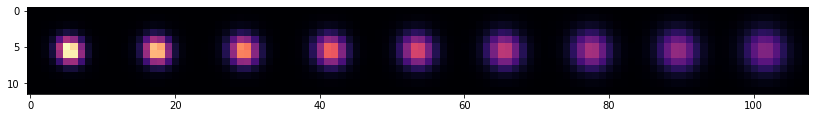

In [12]:
img = np.zeros([fov_pixels, fov_pixels*len(seeing_errs)])
for idx, psf in enumerate(noisy_psfs):
    img[:,fov_pixels*idx:fov_pixels*(idx+1)] = psf
    
plt.figure(figsize=(14,3))
plt.imshow(img, cmap='magma')
plt.imsave('cartoon_seeing.png', img, cmap='magma')

## Shear Error

In [13]:
shear_errs=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
noisy_psfs = []

for shear_err in shear_errs:
    g1_err = shear_err
    g2_err = shear_err
    noisy_psfs.append(get_LSST_PSF(lam, tel_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                                   atmos_fwhm, atmos_e, atmos_beta, g1_err, g2_err,
                                   fov_pixels, pixel_scale=pixel_scale))

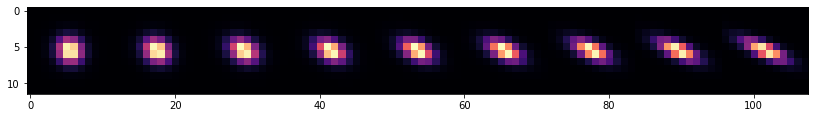

In [14]:
img = np.zeros([fov_pixels, fov_pixels*len(seeing_errs)])
for idx, psf in enumerate(noisy_psfs):
    img[:,fov_pixels*idx:fov_pixels*(idx+1)] = psf
    
plt.figure(figsize=(14,3))
plt.imshow(img, cmap='magma')
plt.imsave('cartoon_shear.png', img, cmap='magma')